Dataset shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

Target distribution:
target
0    164
1    139
Name: count, dtype: int64


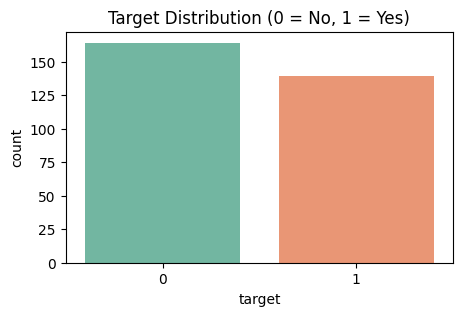


Shape of X after dropping rows with missing target values: (303, 13)
Shape of y after dropping rows with missing target values: (303,)

Train shape: (242, 13) Test shape: (61, 13)

Decision Tree accuracy: 0.738

Classification report (Decision Tree):
               precision    recall  f1-score   support

           0       0.84      0.64      0.72        33
           1       0.67      0.86      0.75        28

    accuracy                           0.74        61
   macro avg       0.75      0.75      0.74        61
weighted avg       0.76      0.74      0.74        61



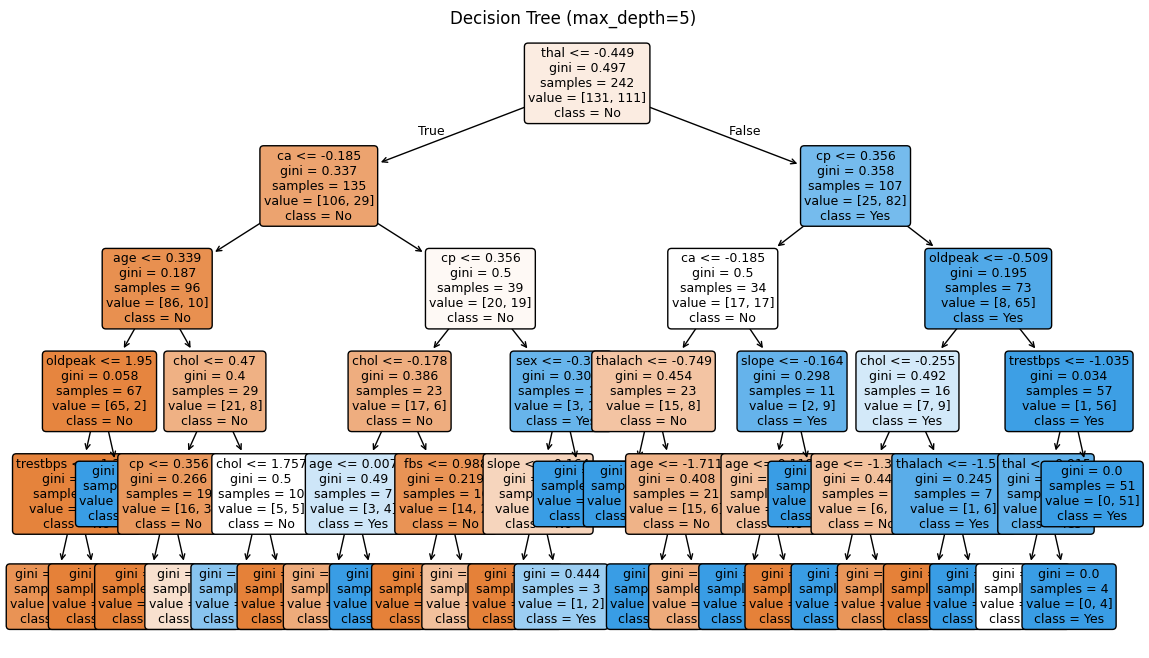

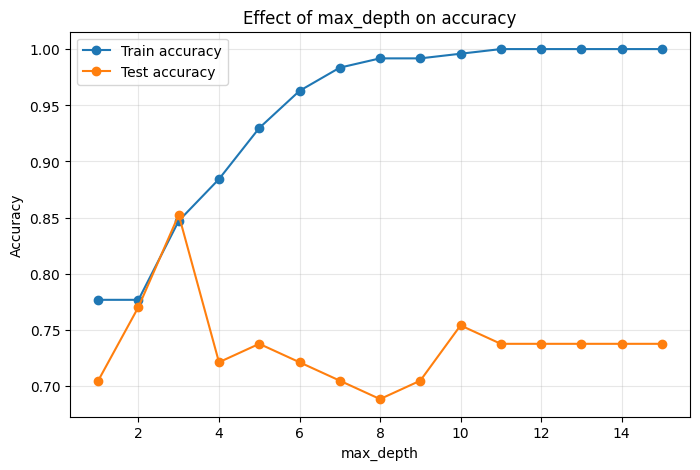

Random Forest accuracy: 0.869

Classification report (Random Forest):
               precision    recall  f1-score   support

           0       0.96      0.79      0.87        33
           1       0.79      0.96      0.87        28

    accuracy                           0.87        61
   macro avg       0.88      0.88      0.87        61
weighted avg       0.89      0.87      0.87        61



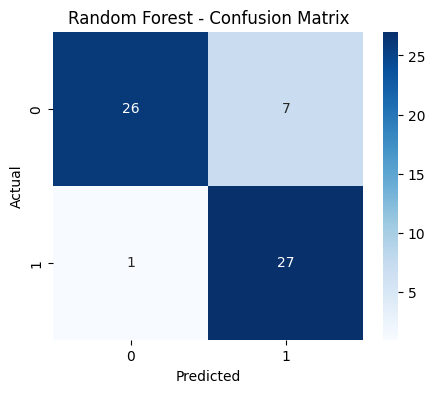

,0
thal,0.145696
thalach,0.122568
cp,0.113065
ca,0.108469
age,0.093588
oldpeak,0.092074
chol,0.085729
trestbps,0.077403
exang,0.051260
slope,0.041315


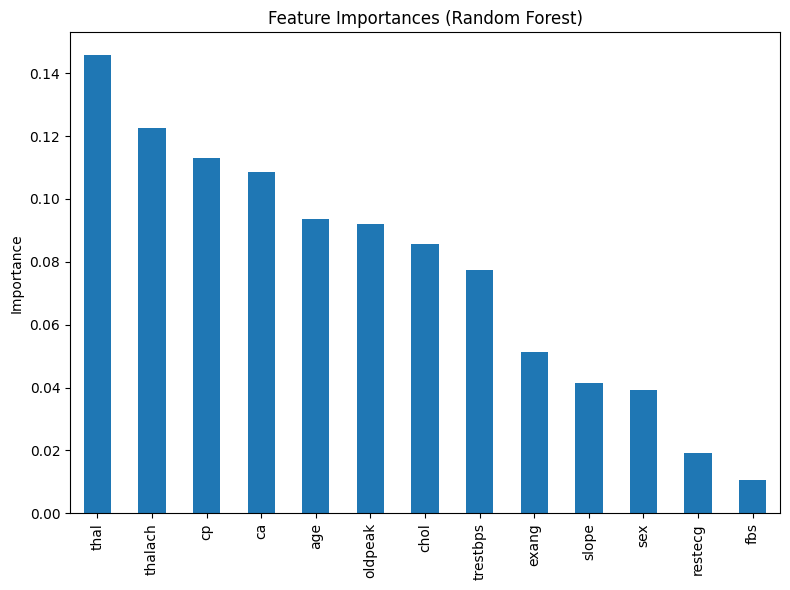


Shape of X_scaled before cross-validation: (303, 13)
Shape of y before cross-validation: (303,)
CV scores: [0.869 0.902 0.82  0.733 0.783]
Mean CV accuracy: 0.821
Summary:
 - Decision Tree (max_depth=5) test accuracy = 0.738
 - Random Forest (200 trees) test accuracy = 0.869
 - Random Forest CV mean accuracy = 0.821
Saved: heart_dataset_used_for_task5.csv and feature_importances_task5.csv


In [22]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import requests
import os
import re


pd.set_option('display.max_columns', None)
%matplotlib inline

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

try:
    df = pd.read_csv(url, names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'], na_values='?')
except Exception as e:
    raise RuntimeError(f"Failed to load dataset from url. Error: {e}")


df['target'] = df['target'].apply(lambda x: 1 if x > 0 else (0 if x == 0 else np.nan))

print("Dataset shape:", df.shape)
display(df.head())

print("Missing values per column:")
print(df.isnull().sum())

print("\nTarget distribution:")
print(df['target'].value_counts())

# Plot target distribution
plt.figure(figsize=(5,3))
sns.countplot(x='target', data=df, palette='Set2')
plt.title("Target Distribution (0 = No, 1 = Yes)")
plt.show()


df_cleaned = df.dropna(subset=['target']).copy()

X = df_cleaned.drop(columns=['target'])
y = df_cleaned['target']

print("\nShape of X after dropping rows with missing target values:", X.shape)
print("Shape of y after dropping rows with missing target values:", y.shape)

# Impute missing values in features
if X.isnull().sum().sum() > 0:
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    X = imputer.fit_transform(X)
    X = pd.DataFrame(X, columns=df_cleaned.drop(columns=['target']).columns) # Convert back to DataFrame to keep column names

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)   # returns numpy array; use X_scaled for model input

# Split (use scaled features)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.20, random_state=42, stratify=y
)

print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)

dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)
print("\nDecision Tree accuracy:", round(acc_dt, 3))
print("\nClassification report (Decision Tree):\n", classification_report(y_test, y_pred_dt))

plt.figure(figsize=(14,8))
plot_tree(
    dt,
    feature_names=df_cleaned.drop(columns=['target']).columns,
    class_names=["No","Yes"],
    filled=True,
    rounded=True,
    fontsize=9
)
plt.title("Decision Tree (max_depth=5)")
plt.show()


depths = list(range(1, 16))
train_scores = []
test_scores = []

for d in depths:
    model = DecisionTreeClassifier(max_depth=d, random_state=42)
    model.fit(X_train, y_train)
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))

plt.figure(figsize=(8,5))
plt.plot(depths, train_scores, label='Train accuracy', marker='o')
plt.plot(depths, test_scores, label='Test accuracy', marker='o')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Effect of max_depth on accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


rf = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)

print("Random Forest accuracy:", round(acc_rf, 3))
print("\nClassification report (Random Forest):\n", classification_report(y_test, y_pred_rf))

cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest - Confusion Matrix")
plt.show()

importances = pd.Series(rf.feature_importances_, index=df_cleaned.drop(columns=['target']).columns).sort_values(ascending=False) # Use original column names for feature importances
display(importances.head(15))

plt.figure(figsize=(8,6))
importances.plot(kind='bar')
plt.title("Feature Importances (Random Forest)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

print("\nShape of X_scaled before cross-validation:", X_scaled.shape)
print("Shape of y before cross-validation:", y.shape)
cv_scores = cross_val_score(rf, X_scaled, y, cv=5, scoring='accuracy', n_jobs=-1)
print("CV scores:", np.round(cv_scores, 3))
print("Mean CV accuracy:", round(cv_scores.mean(), 3))


print("Summary:")
print(f" - Decision Tree (max_depth=5) test accuracy = {acc_dt:.3f}")
print(f" - Random Forest (200 trees) test accuracy = {acc_rf:.3f}")
print(f" - Random Forest CV mean accuracy = {cv_scores.mean():.3f}")


df_cleaned.to_csv("heart_dataset_used_for_task5.csv", index=False)
importances.to_csv("feature_importances_task5.csv")
print("Saved: heart_dataset_used_for_task5.csv and feature_importances_task5.csv")